<a href="https://colab.research.google.com/github/zealtechlab/crack_detection_samples-_new/blob/master/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/

![alt text](.idea/lenet_architecture-768x226.png "Figure 2: The LeNet architecture consists of two sets of convolutional, activation, and pooling layers, followed by a fully-connected layer, activation, another fully-connected, and finally a softmax classifier. We’ll be implementing this network architecture using Keras and Python (image source).")

In [2]:
%%time
train_path = 'content/train'
valid_path = 'content/val'
test_path = 'content/test'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['crack', 'not_crack'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['crack', 'not_crack'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['crack', 'not_crack'], batch_size=32)

Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
CPU times: user 21.2 ms, sys: 3.66 ms, total: 24.8 ms
Wall time: 318 ms


CPU times: user 961 ms, sys: 12.3 ms, total: 973 ms
Wall time: 1.01 s


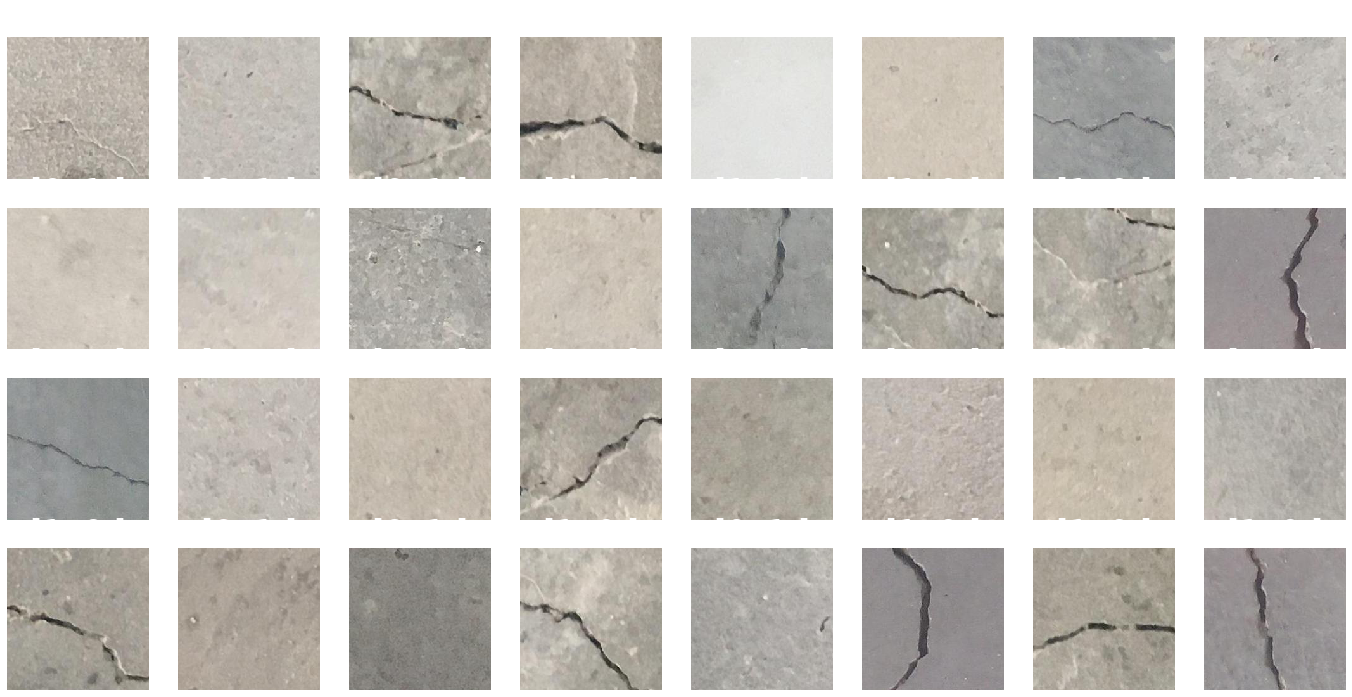

In [15]:
%%time
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % rows == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [4]:
%%time
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

CPU times: user 577 ms, sys: 145 ms, total: 722 ms
Wall time: 732 ms


In [5]:
%%time
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False

CPU times: user 820 µs, sys: 0 ns, total: 820 µs
Wall time: 827 µs


In [6]:
%%time
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________
CPU times: user 502 ms, sys: 165 ms, total: 667 ms
Wall time: 473 ms


In [7]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=5,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3.125 steps, validate for 1.5625 steps
Epoch 1/5
4/3 [======================================] - 79s 20s/step - loss: 7.0741 - acc: 0.4600 - val_loss: 0.1126 - val_acc: 0.9800
Epoch 2/5
4/3 [======================================] - 77s 19s/step - loss: 0.0630 - acc: 0.9700 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 3/5
4/3 [======================================] - 76s 19s/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 4/5
4/3 [======================================] - 75s 19s/step - loss: 0.0102 - acc: 0.9900 - val_loss: 0.0167 - val_acc: 1.0000
Epoch 5/5
4/3 [======================================] - 75s 19s/step - loss: 1.1390e-04 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
CPU times: user 11min 24s, sys: 39.6 s, total: 12min 4s
Wall time: 6min 22s


CPU times: user 27 s, sys: 1.57 s, total: 28.6 s
Wall time: 16.3 s


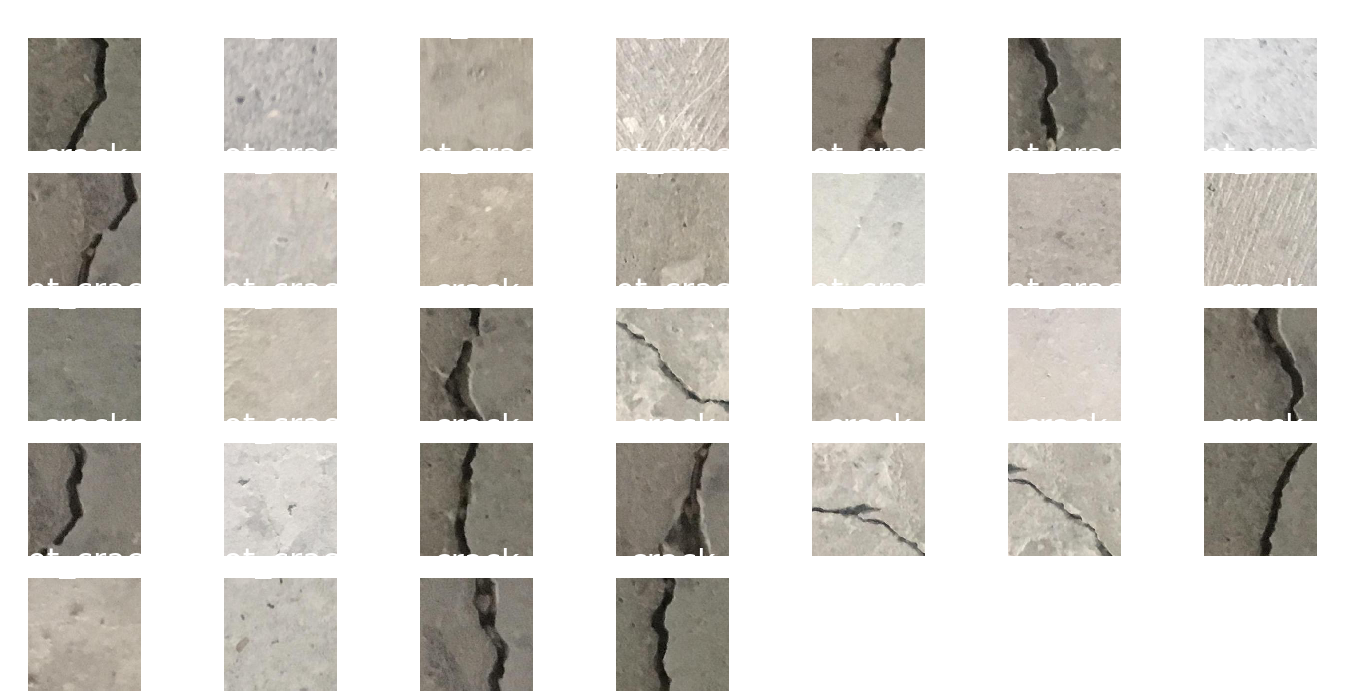

In [16]:
%%time
import pandas as pd
def to_label(value):
    if value==0:
        return 'crack'
    else:
        return 'not_crack'
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:,1]
df['predicted'] = np.round(predictions[:,1])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, rows=5, titles=df['predicted_labels'])

In [23]:
real_batch = ImageDataGenerator().flow_from_directory('Images', target_size=(224,224), classes=['good','bad'], batch_size=32)

Found 40294 images belonging to 2 classes.


CPU times: user 27 s, sys: 1.25 s, total: 28.2 s
Wall time: 16.7 s


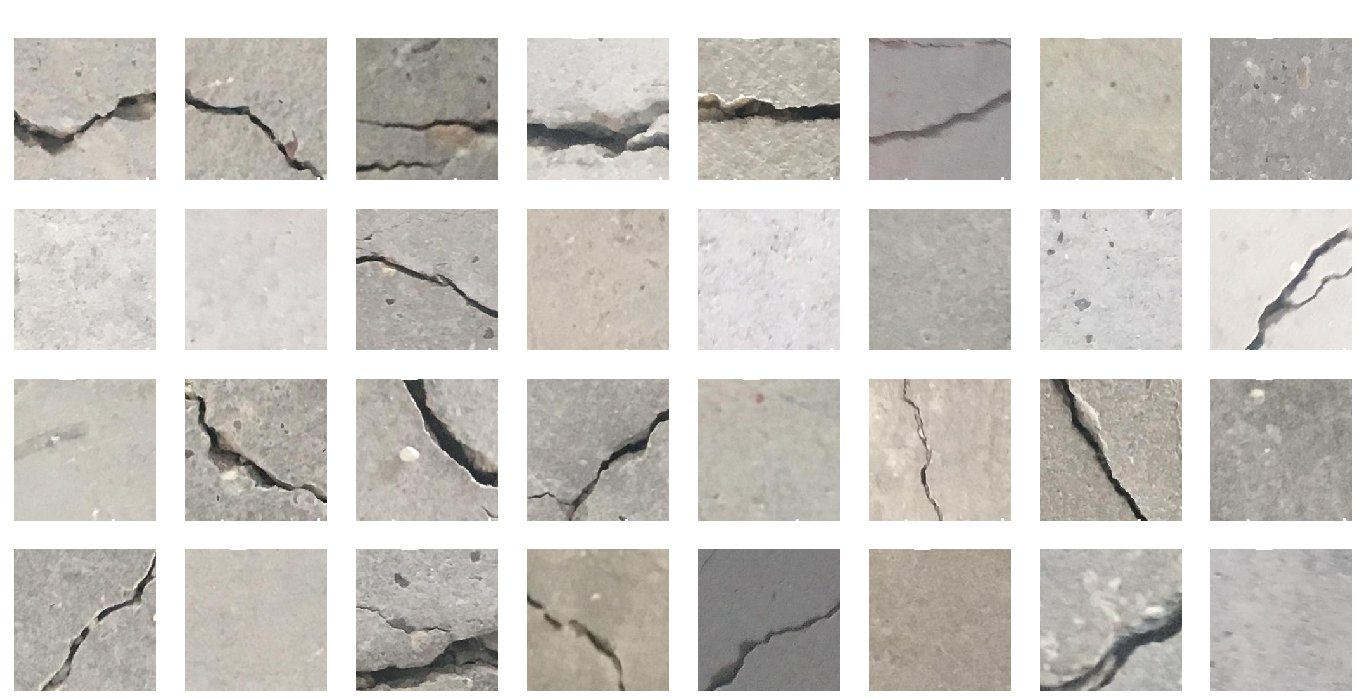

In [24]:
%%time

test_imgs, test_labels = next(real_batch)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:,1]
df['predicted'] = np.round(predictions[:,1])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])